In [13]:
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import albumentations as A
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [14]:
class FieldModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            self._block(1, 32, 3),
            self._block(32, 48, 3),
            self._block(48, 64, 3),
            self._block(64, 80, 3),
            self._block(80, 96, 3),
            self._block(96, 112, 3),
            self._block(112, 128, 3),
            self._block(128, 144, 3),
            self._block(144, 160, 3),
            self._block(160, 176, 3),
            Flatten(),
            nn.Linear(11264, 3, bias=False),
            nn.BatchNorm1d(3),
        )

    def _block(self, input_dim, output_dim, kernel_size):
        return nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size, bias=False),
            nn.BatchNorm2d(output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=1)

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x.permute(0, 2, 3, 1), 1)

# 168x168
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 4],
    (256, 3, 2),
    ["B", 4],
    (256, 3, 2),
    ["B", 2],  # To this point is Darknet-53
    (128, 1, 1),
    (64, 3, 1),
    "S",
]
# 36 | 9*4

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

class ScalePrediction(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, in_channels, kernel_size=3, padding=1),
            CNNBlock(in_channels, 16, bn_act=False, kernel_size=1),
            nn.Flatten(),
            nn.Linear(576, 36),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.pred(x)

class BoardModel(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        for layer in self.layers:
          x = layer(x)
        return torch.flatten(x, start_dim=1)

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for idx, module in enumerate(config):
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size >= 2 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                layers += [
                    ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                    CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                    ScalePrediction(in_channels // 2),
                ]
        return layers

# tictactoe models
fieldModel = FieldModel()
fieldModel.load_state_dict(torch.load('detect/tictactoeField.pth', map_location='cpu'))
fieldModel.eval()
boardModel = BoardModel()
boardModel.load_state_dict(torch.load('detect/tictactoeBoard.pth', map_location='cpu'))
boardModel.eval()
print()


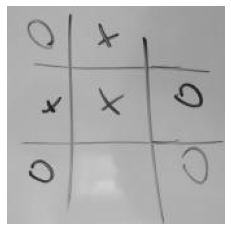

In [15]:
image = Image.open('data/boards/raw/0.jpg')
image = image.resize((168, 168), Image.ANTIALIAS)
fig, ax = plt.subplots(1)
plt.axis('off')
ax.imshow(image)

image = image.convert('L')

In [16]:
# transform = A.Compose([
#     A.InvertImg(p=0.18),
#     A.ColorJitter(brightness=0.55, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
#     A.GaussNoise(p=0.28),
#     A.Blur(blur_limit=4, p=0.22),
#     A.GlassBlur(max_delta=1, iterations=1, p=0.14),
#     A.CLAHE(p=0.3),
#     A.Sharpen(p=0.2),
#     A.Emboss(p=0.18),
#     A.Equalize(p=0.05),
#     A.MultiplicativeNoise(p=0.22),
# ])

# image1 = np.array(image)
# image1 = transform(image=image1)['image']
# plt.imshow(image1, cmap='gray')

[[0.1611324  0.13810033 0.22305092 0.21726467]
 [0.46493632 0.15133886 0.3191441  0.22233939]
 [0.81519264 0.15175565 0.28440255 0.2370522 ]
 [0.15535606 0.44307214 0.2350409  0.31676826]
 [0.4775641  0.4524676  0.3141364  0.30174798]
 [0.8274337  0.46207717 0.27629432 0.2852472 ]
 [0.158868   0.79367447 0.21267454 0.28008637]
 [0.48934412 0.7942165  0.34544078 0.30110428]
 [0.835973   0.7882841  0.23804045 0.30226672]]


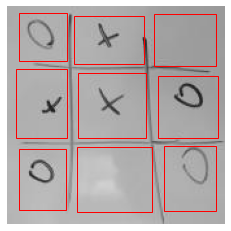

In [17]:
imageT = to_tensor(image).reshape(1, 1, 168, 168)
out = boardModel(imageT).reshape(9, 4).cpu().detach().numpy()

print(out)

fields = []

for box in out:
    x, y, w, h = box
    x, y, w, h = 168 * x, 168 * y, 168 * w, 168 * h
    im1 = image.crop(
        (x - w / 2, y - h / 2, x + w / 2, y + h / 2)
    )
    im1 = im1.resize((28, 28), Image.ANTIALIAS)
    im1 = to_tensor(im1)
    fields.append(im1)
    rect = Rectangle(
        (x - w / 2, y - h / 2),
        w,
        h,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

fields = torch.stack(fields)
out = fieldModel(fields)
state = out.argmax(1).numpy().reshape(3, 3) - 1
fig


In [18]:
for field in fieldDict.values():
    fieldImg = field.numpy().reshape(28, 28)
    plt.imshow(fieldImg, cmap='gray')
    plt.show()

NameError: name 'fieldDict' is not defined